In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision

from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import matplotlib.pyplot as plt

In [2]:
import argparse
from src.solver import TASKS
from src.core import YAMLConfig

config = '/home/prml/StudentsWork/Chanyoung/RM-DETR/configs/rm-detr/r50_250311.yml'
pt_path = '/home/prml/StudentsWork/Chanyoung/RM-DETR/output/r50_250312/best.pth'
cfg = YAMLConfig(
       config, resume=pt_path, use_amp=False, tuning=False
    )
solver = TASKS[cfg.yaml_cfg["task"]](cfg)
print(solver)

In [5]:
device = "cuda"
solver.setup
solver.eval()
model = solver.model
model.to(device)
model.eval()
postprocessor = solver.postprocessor
print(postprocessor)

resume from /home/prml/StudentsWork/Chanyoung/RM-DETR/output/r50_250312/best.pth
Loading last_epoch
Loading model.state_dict
Loading ema.state_dict
RMDETRPostProcessor(use_focal_loss=True, num_classes=80, num_top_queries=300)


In [48]:
import requests
import torchvision
from PIL import Image
# image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
image = Image.open('/home/prml/StudentsWork/Chanyoung/RM-DETR/dogs.jpg')


transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640,640)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)
print(input_tensor.shape)

# 모델 forward pass
output = model(input_tensor)
print(output.keys())

post_output = postprocessor(output, torch.tensor([[430, 710]]).to(device))
print(post_output[0].keys())

torch.Size([1, 3, 640, 640])
dict_keys(['pred_logits', 'pred_boxes', 'pred_masks'])
dict_keys(['labels', 'boxes', 'scores', 'masks'])


In [43]:
import torch
import numpy as np
import cv2
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

def visualize_highest_score_object(output, image_path, original_image_size):
    """
    가장 확률이 큰 객체를 시각화하고 플롯합니다.

    Args:
        output (dict): 모델의 출력 (pred_logits, pred_boxes, pred_masks).
        image_path (str): 이미지 파일 경로.
        original_image_size (tuple): 원본 이미지 크기 (height, width).

    Returns:
        numpy.ndarray: 객체가 시각화된 이미지.
    """

    pred_logits = output['pred_logits']
    pred_boxes = output['pred_boxes']
    pred_masks = output['pred_masks']

    # 확률 계산 및 가장 높은 확률 객체 선택
    probs = torch.softmax(pred_logits, dim=-1)[0]  # [1, 300, 80] -> [300, 80]
    max_prob, max_class = torch.max(probs[:, :-1], dim=-1)  # 배경 제외
    highest_score_idx = torch.argmax(max_prob)

    # 객체 정보 추출
    box = pred_boxes[0, highest_score_idx]
    mask = pred_masks[0, highest_score_idx]
    class_id = max_class[highest_score_idx].item()
    score = max_prob[highest_score_idx].item()

    # 마스크 이진화 및 이미지 크기 조정
    mask = mask.sigmoid().detach().cpu().numpy()

    # 이미지 로드
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(image.shape)
    # 마스크 크기 조정
    mask = cv2.resize(mask, (image.shape[1], image.shape[0])) # (160, 160) -> (W, H)
    mask = (mask > 0.5).astype(np.uint8)

    # 바운딩 박스 좌표 계산
    H, W = image.shape[:2]
    box = box.cpu()
    x1, y1, x2, y2 = box * torch.tensor([W, H, W, H])
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    # 시각화
    color = (0, 255, 0)  # 초록색
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    image[mask == 1] = image[mask == 1] * 0.5 + np.array(color) * 0.5  # 마스크 영역 색상 변경
    cv2.putText(image, f"Class: {class_id}, Score: {score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 플롯
    plt.imshow(image)
    plt.axis('off')  # 축 제거
    plt.show()

    return image

(430, 710, 3)


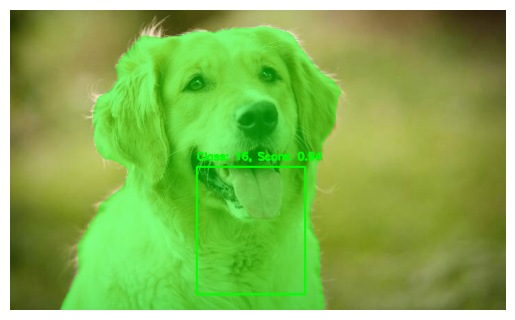

array([[[56, 64, 17],
        [56, 64, 17],
        [55, 63, 16],
        ...,
        [43, 35, 14],
        [43, 35, 14],
        [43, 35, 14]],

       [[55, 63, 16],
        [55, 63, 16],
        [55, 63, 16],
        ...,
        [43, 35, 14],
        [43, 35, 14],
        [43, 35, 14]],

       [[54, 62, 15],
        [54, 62, 15],
        [54, 62, 15],
        ...,
        [43, 35, 14],
        [43, 35, 14],
        [43, 35, 14]],

       ...,

       [[64, 76, 12],
        [64, 76, 12],
        [65, 77, 13],
        ...,
        [79, 89, 37],
        [79, 89, 37],
        [78, 88, 36]],

       [[63, 75, 11],
        [64, 76, 12],
        [64, 76, 12],
        ...,
        [79, 89, 37],
        [78, 88, 36],
        [78, 88, 36]],

       [[63, 75, 11],
        [63, 75, 11],
        [64, 76, 12],
        ...,
        [78, 88, 36],
        [78, 88, 36],
        [77, 87, 35]]], shape=(430, 710, 3), dtype=uint8)

In [44]:
visualize_highest_score_object(output, '/home/prml/StudentsWork/Chanyoung/RM-DETR/dogs.jpg', (640, 640))

In [74]:
import torch
import numpy as np
import cv2
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

def visualize_highest_score_object2(post_output, image_path):
    """
    후처리 결과에서 점수가 가장 큰 객체 하나만 시각화하고 플롯합니다.

    Args:
        post_output (dict): 후처리 결과 (labels, boxes, scores, masks).
        image_path (str): 이미지 파일 경로.

    Returns:
        numpy.ndarray: 객체가 시각화된 이미지.
    """

    labels = post_output['labels'].detach().cpu().numpy()
    boxes = post_output['boxes'].detach().cpu().numpy()
    scores = post_output['scores'].detach().cpu().numpy()
    masks = post_output['masks'].detach().cpu().numpy()

    # 이미지 로드
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if len(scores) > 0:  # 객체가 하나 이상 검출되었을 경우
        # 가장 높은 점수의 객체 인덱스 찾기
        highest_score_idx = np.argmax(scores)

        # 객체 정보 추출
        label = labels[highest_score_idx]
        box = boxes[highest_score_idx]
        score = scores[highest_score_idx]
        mask = masks[highest_score_idx]

        # 마스크 이진화 및 이미지 크기 조정
        # mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
        mask = (mask > 0.5).astype(np.uint8)
        print(mask)
        # 바운딩 박스 좌표 계산
        H, W, _ = image.shape
        x1, y1, x2, y2 = box * np.array([W, H, W, H])
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        # 시각화
        color = (0, 255, 0)  # 초록색
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image[mask == 1] = image[mask == 1] * 0.5 + np.array(color) * 0.5  # 마스크 영역 색상 변경
        cv2.putText(image, f"Class: {label}, Score: {score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 플롯
    plt.imshow(image)
    plt.axis('off')  # 축 제거
    plt.show()

    # return image

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


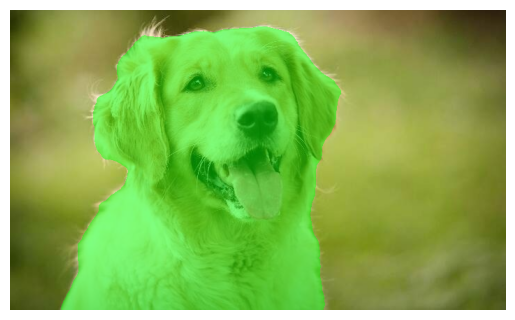

In [75]:
visualize_highest_score_object2(post_output[0], '/home/prml/StudentsWork/Chanyoung/RM-DETR/dogs.jpg')

In [ ]:

def verify_rle(mask):
    """RLE 인코딩 및 디코딩 검증."""

    rle = mask_util.encode(np.asfortranarray(mask, dtype=np.uint8))
    decoded_mask = mask_util.decode(rle)

    if np.array_equal(mask, decoded_mask):
        print("RLE encoding and decoding are successful.")
        return True
    else:
        print("RLE encoding or decoding failed.")
        return False

# 예시 마스크 생성
mask = np.zeros((100, 100), dtype=np.uint8)
mask[20:40, 30:50] = 1

# RLE 검증
verify_rle(mask)